# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import estimate_market_factors as emf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-06-24"

## Load data and filter duplicates by symbol and date

In [20]:
# Standard and Poor's 500 - S&P 500 (United States)
df_stock_index = pd.read_pickle("{}/df_stock_index_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
# Mexico Price and Quote Index (Mexico)
#df_stock_index = pd.read_pickle("{}/df_stock_index_mxx_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)

## Entropy matrix (proof)

In [21]:
column_ = "z_score_log_return"

# Standard and Poor's 500 - S&P 500 (United States)
shares_pair = ["EW", "SWKS"]

# Mexico Price and Quote Index (Mexico)
#shares_pair = ["CUERVO.MX", "GCC.MX"]


In [22]:
ee.estimate_entropy_pairs(
    df = df_stock_index,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    entropy_args_list = (shares_pair[0], shares_pair[1], 76, 50)
)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,EW,SWKS,2.057166,2.506147,4.429826,0.133488,4.296338,0.030134
1,SWKS,EW,2.057166,2.506147,4.429826,0.133488,4.296338,0.030134


In [23]:
ee.estimate_entropy_matrix(
    df = df_stock_index[df_stock_index["symbol"].isin(shares_pair)],
    min_bins = 10,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True
)

100%|█████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,EW,EW,2.070238,2.070238,2.070238,2.070238,0.000000,1.0000
0,EW,SWKS,2.070238,2.945780,4.868975,0.147043,4.721932,0.0302
1,SWKS,EW,2.070238,2.945780,4.868975,0.147043,4.721932,0.0302
0,SWKS,SWKS,2.945780,2.945780,2.945780,2.945780,0.000000,1.0000


## Construct covariance matrix and compare with entropy matrix

In [24]:
df_final = emf.get_market_efficiency_data_window(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = column_,
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2007-01-01", "2009-12-31")
)

df_final[df_final["symbol_x"] != df_final["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 990/990 [00:22<00:00, 44.32it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
667,2007-01-01,2009-12-31,EW,SWKS,1.938959,2.136102,3.859220,0.215840,3.643380,0.055928,0.944072,0.249080
668,2007-01-01,2009-12-31,SWKS,EW,1.938959,2.136102,3.859220,0.215840,3.643380,0.055928,0.944072,0.249080
211,2007-01-01,2009-12-31,AWK,SWKS,2.143677,2.136102,4.119908,0.159872,3.960036,0.038805,0.961195,0.250966
212,2007-01-01,2009-12-31,SWKS,AWK,2.143677,2.136102,4.119908,0.159872,3.960036,0.038805,0.961195,0.250966
641,2007-01-01,2009-12-31,EW,GLW,1.938959,2.432747,4.098435,0.273270,3.825165,0.066677,0.933323,0.272269
...,...,...,...,...,...,...,...,...,...,...,...,...
66,2007-01-01,2009-12-31,WFC,AIZ,1.899622,2.048972,3.506232,0.442362,3.063870,0.126165,0.873835,2.184787
1793,2007-01-01,2009-12-31,WELL,WFC,2.301608,2.048972,3.855352,0.495229,3.360124,0.128452,0.871548,2.196840
1794,2007-01-01,2009-12-31,WFC,WELL,2.301608,2.048972,3.855352,0.495229,3.360124,0.128452,0.871548,2.196840
1514,2007-01-01,2009-12-31,TROW,WFC,2.353236,2.048972,3.824225,0.577984,3.246241,0.151137,0.848863,2.506497


In [25]:
df_final_2 = emf.get_market_efficiency_data_window(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2007-01-01", "2009-12-31")
)

df_final_2[df_final_2["symbol_x"] != df_final_2["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 990/990 [00:20<00:00, 48.85it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
213,2007-01-01,2009-12-31,AWK,TROW,2.245016,2.286566,4.373576,0.158006,4.215570,0.036127,0.963873,-0.334751
214,2007-01-01,2009-12-31,TROW,AWK,2.245016,2.286566,4.373576,0.158006,4.215570,0.036127,0.963873,-0.334751
1770,2007-01-01,2009-12-31,WEC,WFC,2.386904,2.079421,4.225770,0.240555,3.985215,0.056926,0.943074,-0.289472
1771,2007-01-01,2009-12-31,WFC,WEC,2.386904,2.079421,4.225770,0.240555,3.985215,0.056926,0.943074,-0.289472
1658,2007-01-01,2009-12-31,WAT,WFC,1.575068,2.079421,3.479240,0.175249,3.303992,0.050370,0.949630,-0.281376
...,...,...,...,...,...,...,...,...,...,...,...,...
1794,2007-01-01,2009-12-31,WFC,WELL,2.064769,2.079421,3.886920,0.257271,3.629649,0.066189,0.933811,0.323839
1514,2007-01-01,2009-12-31,TROW,WFC,2.286566,2.079421,4.090570,0.275418,3.815152,0.067330,0.932670,0.324227
1515,2007-01-01,2009-12-31,WFC,TROW,2.286566,2.079421,4.090570,0.275418,3.815152,0.067330,0.932670,0.324227
1181,2007-01-01,2009-12-31,PNW,WEC,2.298735,2.386904,4.292649,0.392990,3.899659,0.091550,0.908450,0.514710


symbol       date  EW      SWKS  temp_1    temp_2  mask
0      2000-01-04 NaN  0.000000     NaN  0.000000     1
1      2000-01-05 NaN  0.668527     NaN  0.668527     1
2      2000-01-06 NaN -2.706222     NaN -2.706222     1
3      2000-01-07 NaN  2.572648     NaN  2.572648     1
4      2000-01-10 NaN -1.478665     NaN -1.478665     1


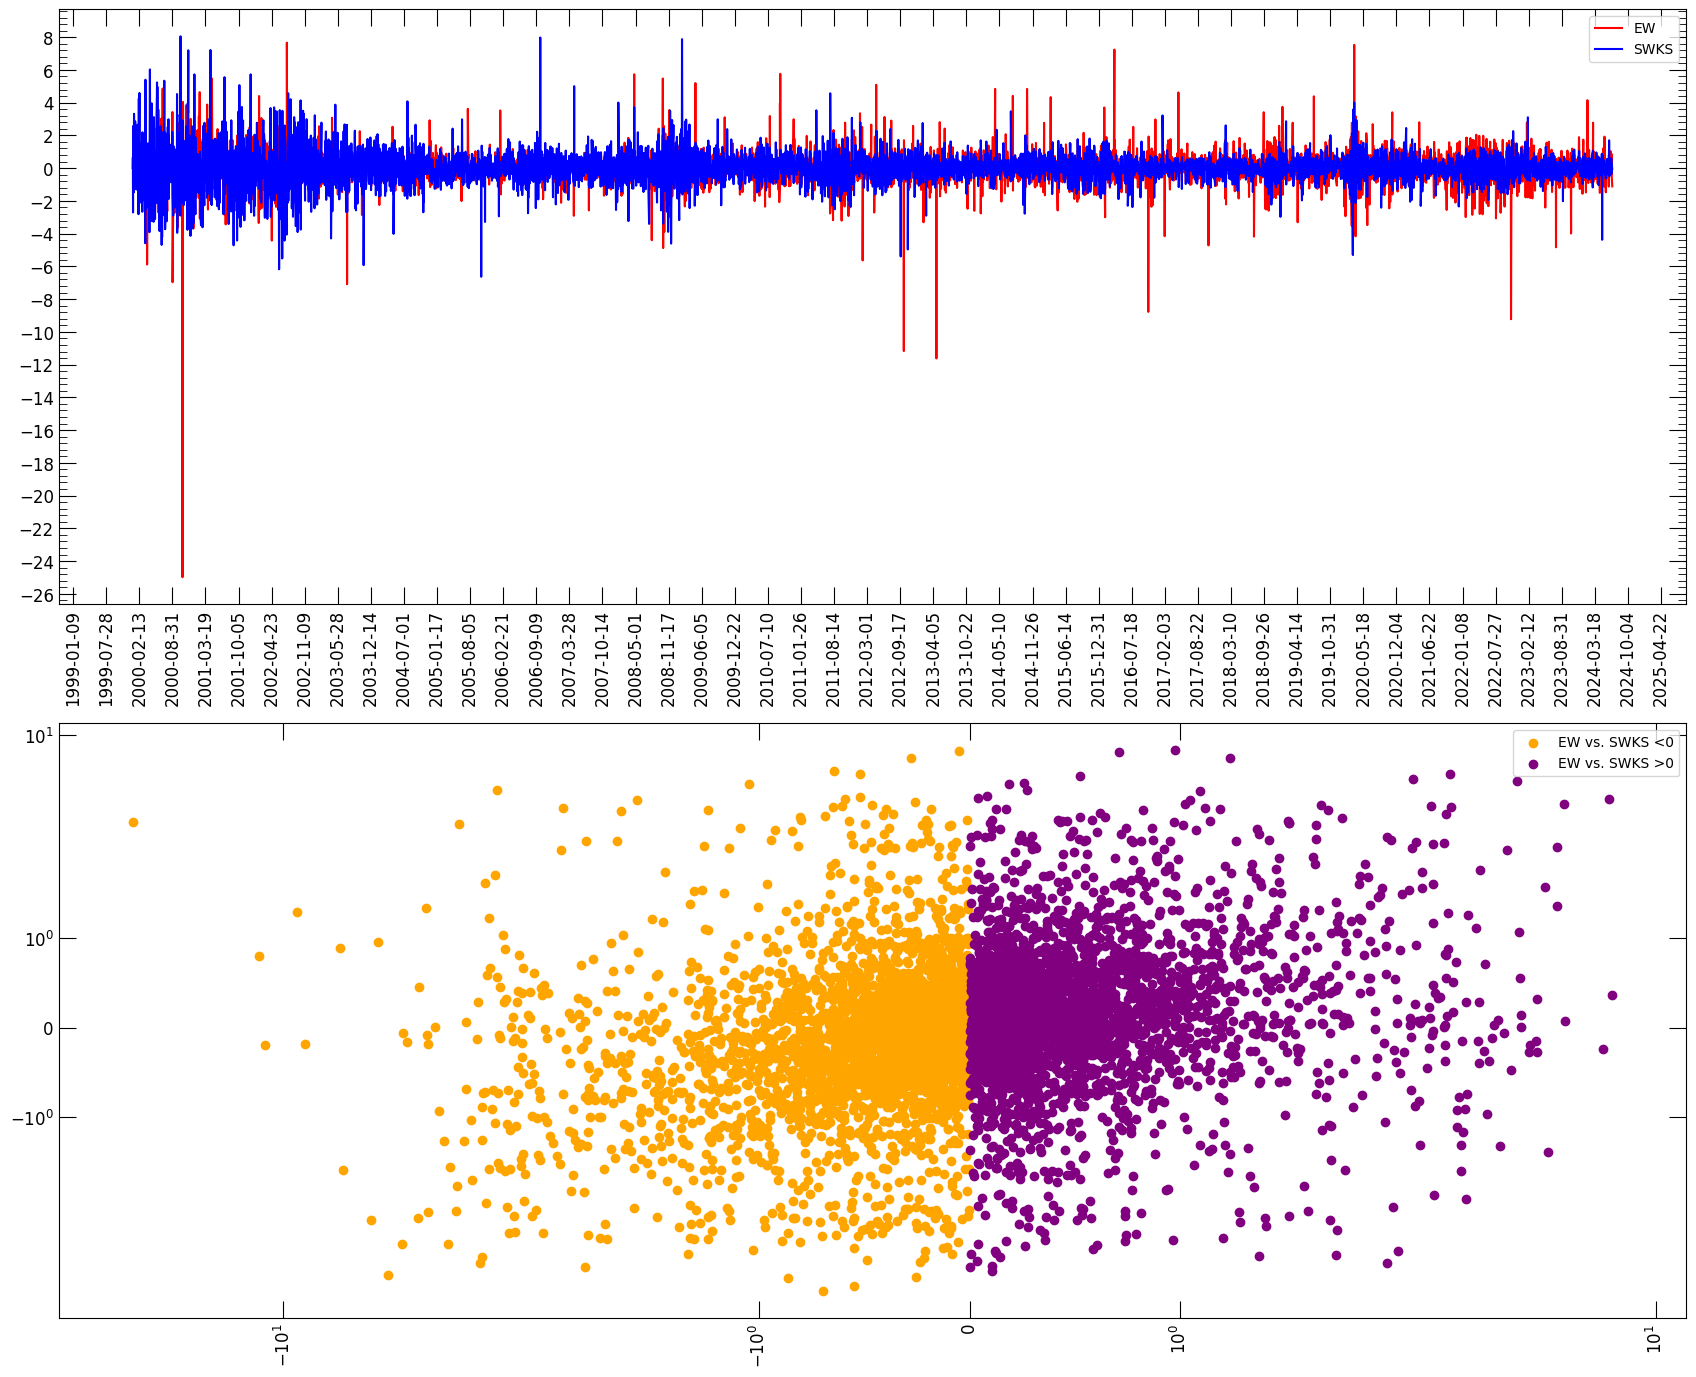

In [26]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1]))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1]))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


In [27]:
import importlib
importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_log_return",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_final_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2018-01-01", "2019-01-01"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5]
)

100%|███████████████████| 1485/1485 [00:52<00:00, 28.09it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy
0,2018-01-01,2019-01-01,z_score_log_return,0,0,0.01,6,1,1,3,8
1,2018-01-01,2019-01-01,z_score_log_return,0,0,0.05,6,1,1,3,8
2,2018-01-01,2019-01-01,z_score_log_return,0,0,0.10,6,1,1,3,8
3,2018-01-01,2019-01-01,z_score_log_return,0,0,0.01,6,1,2,7,8
4,2018-01-01,2019-01-01,z_score_log_return,0,0,0.05,6,1,2,7,8
5,2018-01-01,2019-01-01,z_score_log_return,0,0,0.10,6,1,2,7,8
6,2018-01-01,2019-01-01,z_score_log_return,0,0,0.01,6,1,5,8,8
7,2018-01-01,2019-01-01,z_score_log_return,0,0,0.05,6,1,5,8,8
8,2018-01-01,2019-01-01,z_score_log_return,0,0,0.10,6,1,5,8,8


In [28]:
import importlib
importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_final_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2018-01-01", "2019-01-01"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5]
)

100%|███████████████████| 1485/1485 [00:20<00:00, 71.20it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy
0,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.01,19,1,1,0,8
1,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.05,19,1,1,0,8
2,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.10,19,1,1,0,8
3,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.01,19,1,2,0,8
4,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.05,19,1,2,0,8
5,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.10,19,1,2,0,8
6,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.01,19,1,5,0,8
7,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.05,19,1,5,0,8
8,2018-01-01,2019-01-01,z_score_zlr_no_market,0,0,0.10,19,1,5,0,8


## Compare spectrum

In [29]:
from scipy.linalg import eigh # type: ignore

df_1 = (
    df_final[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_2 = (
    df_final[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_3 = (
    df_final[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_4 = (
    df_final_2[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_5 = (
    df_final_2[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_6 = (
    df_final_2[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_7 = pd.DataFrame(
    {
        "eigenvalues_correlation" : eigh(df_1)[0],
        "eigenvalues_entropy" : eigh(df_2)[0],
        "eigenvalues_entropy_modified" : eigh(df_3)[0],
        "eigenvalues_correlation_res" : eigh(df_4)[0],
        "eigenvalues_entropy_res" : eigh(df_5)[0],
        "eigenvalues_entropy_modified_res" : eigh(df_6)[0]
    }
).value_counts(dropna = False, sort = False).reset_index()

df_7

,eigenvalues_correlation,eigenvalues_entropy,eigenvalues_entropy_modified,eigenvalues_correlation_res,eigenvalues_entropy_res,eigenvalues_entropy_modified_res,count
0,0.263867,0.826555,-1.181743,-0.030583,0.875587,-1.072515,1
1,0.283859,0.842540,-1.048657,0.373425,0.902927,-1.017340,1
2,0.289357,0.846671,-1.035882,0.436718,0.910606,-1.002287,1
3,0.312010,0.852816,-1.012197,0.453184,0.922252,-0.999762,1
4,0.340663,0.859233,-0.994213,0.484223,0.923563,-0.995417,1
5,0.353505,0.863781,-0.980784,0.509626,0.927026,-0.991448,1
6,0.360103,0.866975,-0.973884,0.524273,0.928949,-0.988934,1
7,0.373322,0.872879,-0.963645,0.539989,0.929526,-0.987537,1
8,0.405091,0.874936,-0.960378,0.561099,0.933233,-0.983492,1
9,0.422014,0.876673,-0.955667,0.597265,0.934421,-0.980853,1


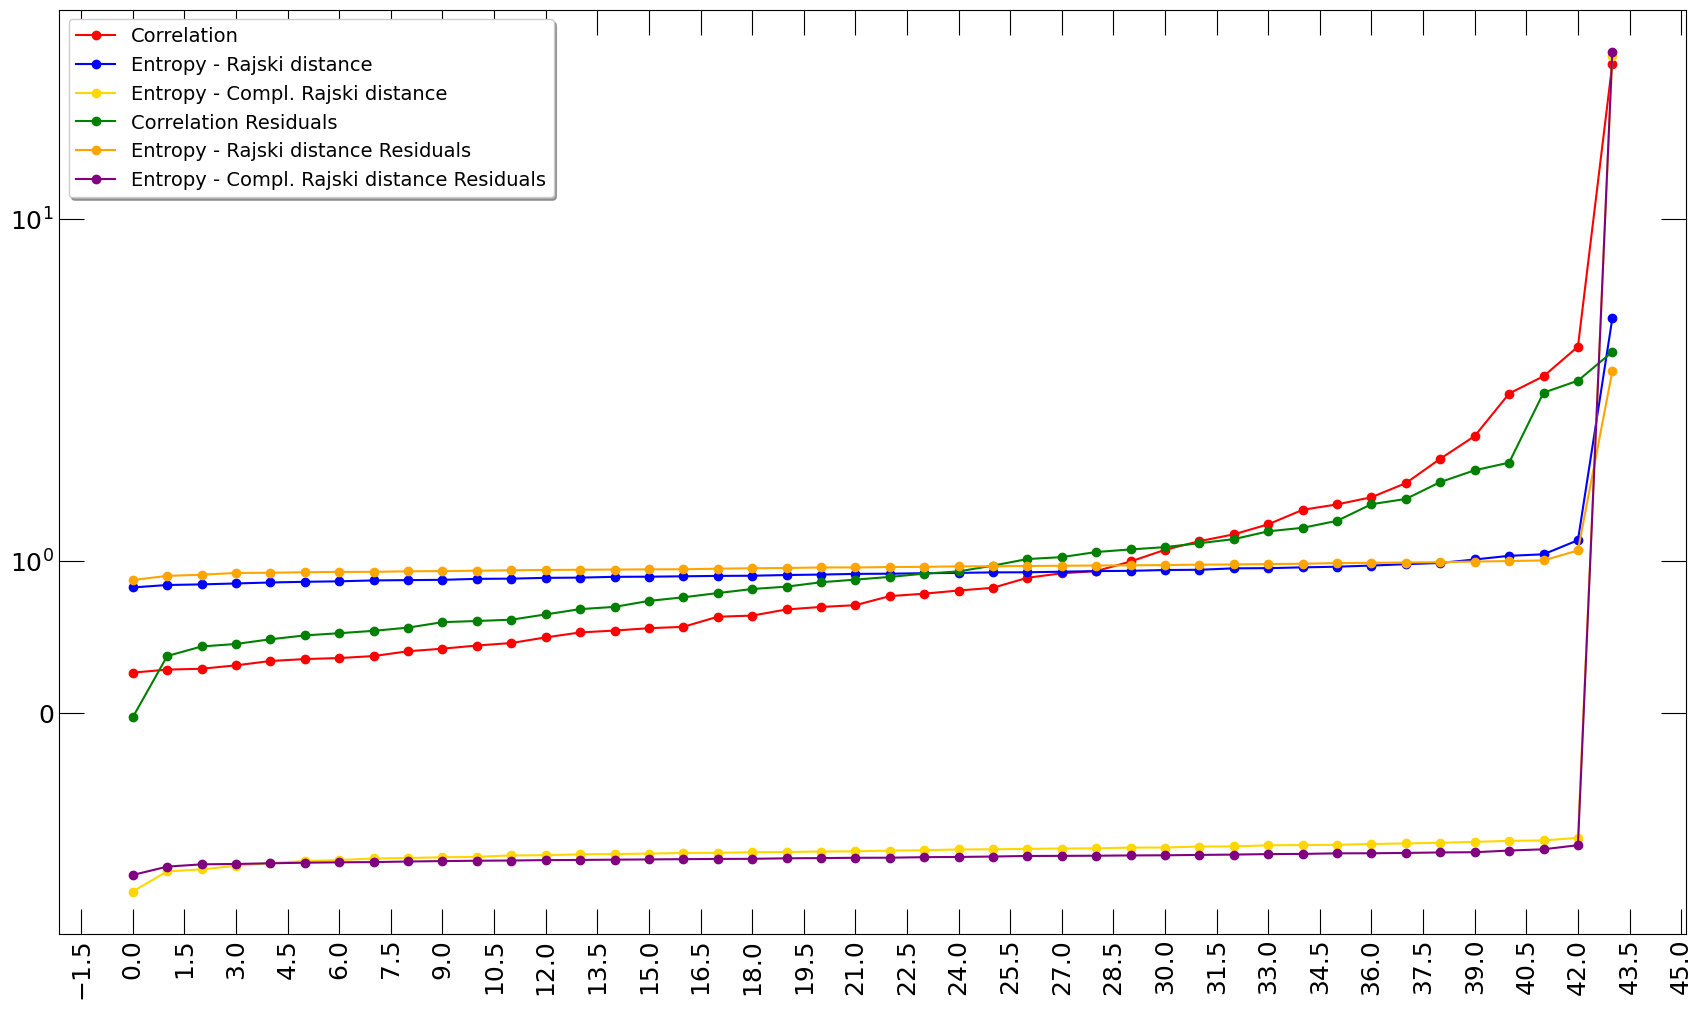

In [30]:
import matplotlib.pyplot as plt # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 12)

df_8 = df_7#.tail(5)

ax.plot(df_8["eigenvalues_correlation"], color = "red", marker = "o", label = "Correlation")
ax.plot(df_8["eigenvalues_entropy"], color = "blue", marker = "o", label = "Entropy - Rajski distance")
ax.plot(df_8["eigenvalues_entropy_modified"], color = "gold", marker = "o", label = "Entropy - Compl. Rajski distance")
ax.plot(df_8["eigenvalues_correlation_res"], color = "green", marker = "o", label = "Correlation Residuals")
ax.plot(df_8["eigenvalues_entropy_res"], color = "orange", marker = "o", label = "Entropy - Rajski distance Residuals")
ax.plot(df_8["eigenvalues_entropy_modified_res"], color = "purple", marker = "o", label = "Entropy - Compl. Rajski distance Residuals")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 18, length = 18)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 18, length = 10)
ax.xaxis.set_major_locator(mtick.MaxNLocator(df_5.shape[0]))
ax.yaxis.set_major_locator(mtick.MaxNLocator(40))
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend(fancybox = True, shadow = True, ncol = 1, fontsize = 14)

#ax.set_xscale(value = "log")
ax.set_yscale(value = "symlog")

plt.show()


## Save data

In [31]:
df_final.to_csv("{}/df_entropy_correlation_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)

#df_final.to_csv("{}/df_entropy_correlation_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)

## Proofs

In [15]:
#p_i = N df.shape[1] #Shares
#q = 1/2
#m = 225
#step = 8
#n_i = int((1/q)*p_i)
#delta = 20
#k1_k0 = 8

#for i in range(m):
#    print(i)
#    start = i*delta
#    end = i*delta + n_i # slicing in dates between start and end through "independent" Windows of size n_i
#    returns = data filtered into start and end date

df = df_stock_index
time_delta = 100
time_step = 20

market_args_list = df[["date"]].sort_values(by = ["date"]).value_counts(sort = False).reset_index()
market_args_list["final_date"] = market_args_list["date"] + pd.DateOffset(days = time_delta)
market_args_list = (
    market_args_list
        .rename(columns = {"date" : "initial_date"})
        .iloc[::time_step]
        .reset_index()
        .drop(columns = ["count", "index"])
)
market_args_list["initial_date"] = market_args_list["initial_date"].astype(str)
market_args_list["final_date"] = market_args_list["final_date"].astype(str)
market_args_list#.values.tolist()


,initial_date,final_date
0,2005-01-04,2005-04-14
1,2005-02-01,2005-05-12
2,2005-03-01,2005-06-09
3,2005-03-30,2005-07-08
4,2005-04-27,2005-08-05
...,...,...
222,2022-08-25,2022-12-03
223,2022-09-23,2023-01-01
224,2022-10-21,2023-01-29
225,2022-11-22,2023-03-02
